# 05 Topic modeling visualization

### https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

## 1. Introduction

In topic modeling with gensim, we followed a structured workflow to build an insightful topic model based on the Latent Dirichlet Allocation (LDA) algorithm.
In this post, we will build the topic model using gensim’s native LdaModel and explore multiple strategies to effectively visualize the results using matplotlib plots.

I will be using a portion of the 20 Newsgroups dataset since the focus is more on approaches to visualizing the results.

Let’s begin by importing the packages and the 20 News Groups dataset.

In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
#from nltk.corpus import stopwords
#stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
#sidesõnad
#stop_words = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
#             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']

#sidesõnad ja asesõnad
stop_words = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju']


%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# 2. Import NewsGroups Dataset

In [2]:
# Import Dataset
df = pd.read_excel('remmelgas/KÕIK TEKSTID_Haabersti_hoberemmelgas.xlsx', engine='openpyxl')
print(df.shape)
df.head()

(306, 8)


,#,title,text,subject,date,link,keywords,subject1
0,1,"Politsei, kokad, emad, muusikud ja lillelapsed...",Eesti Ekspress käis viiel päeval vaatamas koro...,Eesti Ekspress,2021-04-13T21:30:06.000Z,https://ekspress.delfi.ee/artikkel/93112601/po...,NaN,NaN
1,2,FOTOD | Protest jätkub: Toompeale toodi meelt ...,Koroonapiiranguid hõlmava uue seaduseelnõu vas...,Delfi,2021-04-10T08:33:40.000Z,https://www.delfi.ee/artikkel/93094891/fotod-p...,NaN,NaN
2,3,Uus hõberemmelgas? Kohalikud tunnevad muret ha...,"Tõenäoliselt mäletavad paljud, kuidas 2017. aa...",Ärileht,2020-11-21T06:50:02.000Z,https://arileht.delfi.ee/news/uudised/uus-hobe...,NaN,NaN
3,4,MIS SAAB HOMME? | Mati Puss: mis tähtsust on s...,Keskkonnakriisi aina aktuaalsemaks muutudes pü...,Eesti Päevaleht,2019-11-24T11:00:42.000Z,https://epl.delfi.ee/arvamuskonkurss/mis-saab-...,NaN,NaN
4,5,Tallinnas langetatud puu võib tõrjuda Nordecon...,Kahe aasta eest loata raiutud puu võib aktsias...,Ärileht,2019-07-12T13:25:17.000Z,https://arileht.delfi.ee/news/uudised/tallinna...,NaN,NaN


# 3. Tokenize Sentences and Clean

Removing the emails, new line characters, single quotes and finally split the sentence into a list of words using gensim’s simple_preprocess(). Setting the deacc=True option removes punctuations.

In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['eesti', 'ekspress', 'kais', 'viiel', 'paeval', 'vaatamas', 'ja', 'nakkus', 'haiguste', 'ennetamise', 'ja', 'torje', 'seaduse', 'muutmise', 'vastaseid', 'meele', 'avaldusi', 'tallinnas', 'toompeal', 'ja', 'vabaduse', 'valjakul', 'valgus', 'rahu', 'room', 'ja', 'vagi', 'toompeal', 'aprillil', 'kella', 'ajal', 'paike', 'paistab', 'riigikogu', 'hoone', 'ees', 'on', 'sadakond', 'inimest', 'politseiautosid', 'paistab', 'uks', 'politseinikke', 'kaks', 'seltskond', 'on', 'kirev', 'on', 'koroona', 'tottu', 'tootuks', 'jaanud', 'kokkasid', 'muusikuid', 'kelle', 'sissetuleku', 'koroona', 'koomale', 'tombas', 'on', 'talunikke', 'on', 'vanu', 'hipisid', 'siin', 'on', 'tantsuopetajast', 'uksik', 'ema', 'tema', 'tutar', 'kaib', 'esimeses', 'klassis', 'tottu', 'tantsutunde', 'ei', 'toimu', 'millest', 'sa', 'elad', 'siis', 'silvia', 'ilves', 'miks', 'terved', 'inimesed', 'peavad', 'kandma', 'maski', 'eks', 'ma', 'kain', 'linnavalitsuses', 'toetust', 'lunimas', 'soon', 'kapsast', 'peeti', 'porgandit'

# 4. Build the Bigram, Trigram Models and Lemmatize

Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    
    #  nlp = spacy.load("en", disable=['parser', 'ner']) 
    #  see on inglise keele jaoks??
    
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) 
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# 5. Build the Topic Model

To build the LDA topic model using LdaModel(), you need the corpus and the dictionary. Let’s create them first and then build the model. The trained topics (keywords and weights) are printed below as well.

If you examine the topic key words, they are nicely segregate and collectively represent the topics we initially chose: Christianity, Hockey, MidEast and Motorcycles. Nice!

In [5]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())
#> [(0,
#>   '0.017*"write" + 0.015*"people" + 0.014*"organization" + 0.014*"article" + '
#>   '0.013*"time" + 0.008*"give" + 0.008*"first" + 0.007*"tell" + 0.007*"new" + '
#>   '0.007*"question"'),
#>  (1,
#>   '0.008*"christian" + 0.008*"believe" + 0.007*"god" + 0.007*"law" + '
#>   '0.006*"state" + 0.006*"israel" + 0.006*"israeli" + 0.005*"exist" + '
#>   '0.005*"way" + 0.004*"bible"'),
#>  (2,
#>   '0.024*"armenian" + 0.012*"bike" + 0.006*"kill" + 0.006*"work" + '
#>   '0.005*"well" + 0.005*"year" + 0.005*"sumgait" + 0.005*"soldier" + '
#>   '0.004*"way" + 0.004*"ride"'),
#>  (3,
#>   '0.019*"team" + 0.019*"game" + 0.013*"hockey" + 0.010*"player" + '
#>   '0.009*"play" + 0.009*"win" + 0.009*"nhl" + 0.009*"year" + 0.009*"hawk" + '
#>   '0.009*"season"')]

[(0,
  '0.025*"ei" + 0.010*"hoberemmelga" + 0.009*"inimese" + 0.008*"seda" + '
  '0.008*"olek" + 0.007*"sonul" + 0.007*"ole" + 0.007*"teha" + 0.007*"need" + '
  '0.007*"selle"'),
 (1,
  '0.007*"voi" + 0.004*"ridade" + 0.004*"tanava" + 0.004*"jaok" + '
  '0.004*"valituk" + 0.003*"pea" + 0.003*"naitek" + 0.003*"tanavale" + '
  '0.003*"maailma" + 0.003*"poliitika"'),
 (2,
  '0.006*"naitek" + 0.005*"mitte" + 0.005*"voi" + 0.005*"just" + 0.005*"umber" '
  '+ 0.004*"need" + 0.004*"esimene" + 0.004*"uue" + 0.004*"seda" + '
  '0.004*"jaok"'),
 (3,
  '0.005*"eelmise" + 0.004*"valitsuse" + 0.004*"nadala" + 0.004*"taotluse" + '
  '0.004*"kinni" + 0.003*"menetluse" + 0.003*"mik" + 0.003*"votmise" + '
  '0.003*"mehe" + 0.003*"objektide"')]


# 6. What is the Dominant topic and its percentage contribution in each document

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [6]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4506,"ei, hoberemmelga, inimese, seda, olek, sonul, ...","[vaatama, nakkus, haiguste, ennetamise, torje,..."
1,1,3.0,0.4339,"eelmise, valitsuse, nadala, taotluse, kinni, m...","[eestimaalase, toompeal, vaimus, protestijate,..."
2,2,0.0,0.8699,"ei, hoberemmelga, inimese, seda, olek, sonul, ...","[toenaoliselt, kuida, ule, rajamine, ei, saak,..."
3,3,1.0,0.5526,"voi, ridade, tanava, jaok, valituk, pea, naite...","[tulenevaid, lahendusi, liberalism, konservati..."
4,4,3.0,0.5951,"eelmise, valitsuse, nadala, taotluse, kinni, m...","[eest, loata, aktsiaseltsi, idapiiri, rohutab,..."
5,5,0.0,0.6361,"ei, hoberemmelga, inimese, seda, olek, sonul, ...","[skandaali, pohjustanud, aktivist, indrek_vain..."
6,6,0.0,0.6331,"ei, hoberemmelga, inimese, seda, olek, sonul, ...","[skandaali, pohjustanud, aktivist, indrek_vain..."
7,7,0.0,0.7286,"ei, hoberemmelga, inimese, seda, olek, sonul, ...","[volikogu, isamaa, fraktsiooni, esimee, facebo..."
8,8,0.0,0.4836,"ei, hoberemmelga, inimese, seda, olek, sonul, ...","[kuulsuse, hoberemmelgas, tanasek, sootuk, sad..."
9,9,0.0,0.9755,"ei, hoberemmelga, inimese, seda, olek, sonul, ...","[hoberemmelga, mahavotmisest, kirglikud, kuuls..."


# 7. The most representative sentence for each topic

Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [7]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9972,"ei, hoberemmelga, inimese, seda, olek, sonul, ole, teha, need, selle","[tagasi, koo, hendrik, viljandimaa, pohjusel, kokku, retkejuhik, viljandimaa, noortekeskus, lood..."
1,1.0,0.8244,"voi, ridade, tanava, jaok, valituk, pea, naitek, tanavale, maailma, poliitika","[draamateatri, nargenfestivali, uhine, suvelavastus, metsa, forte, teatrisarja, lokkeplatsile, v..."
2,2.0,0.9963,"naitek, mitte, voi, just, umber, need, esimene, uue, seda, jaok","[hoberemmelga, umber, puuduta, mitte, ainult, puukallistajaid, paljusid, inimesi, moistavad, opi..."
3,3.0,0.7972,"eelmise, valitsuse, nadala, taotluse, kinni, menetluse, mik, votmise, mehe, objektide","[remmelga, vestemeister, arult, parnus, puud, tartus, vorus, viljandi, tapal, narvas, kuressaare..."


# 8. Frequency Distribution of Word Counts in Documents

When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

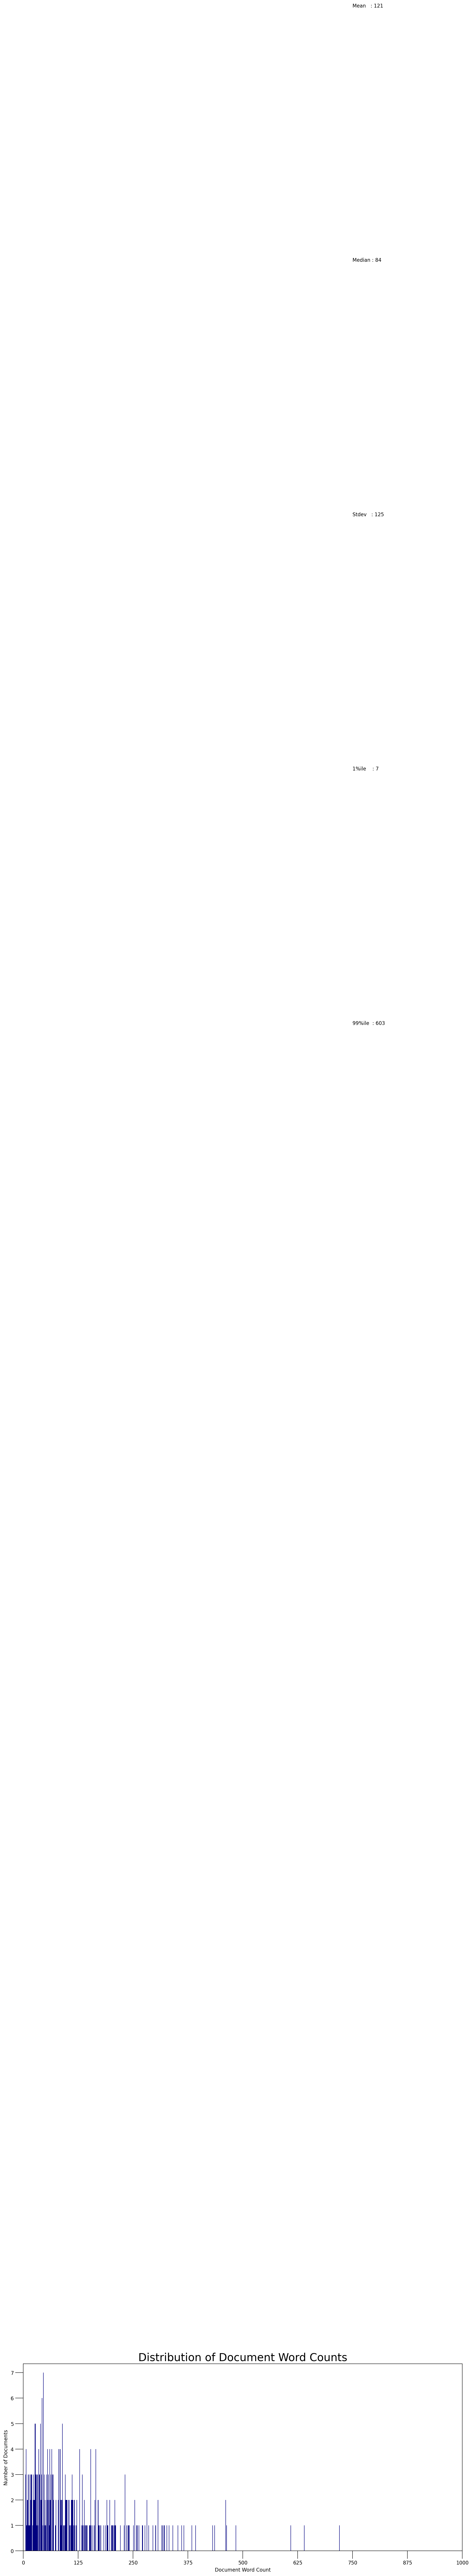

In [8]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

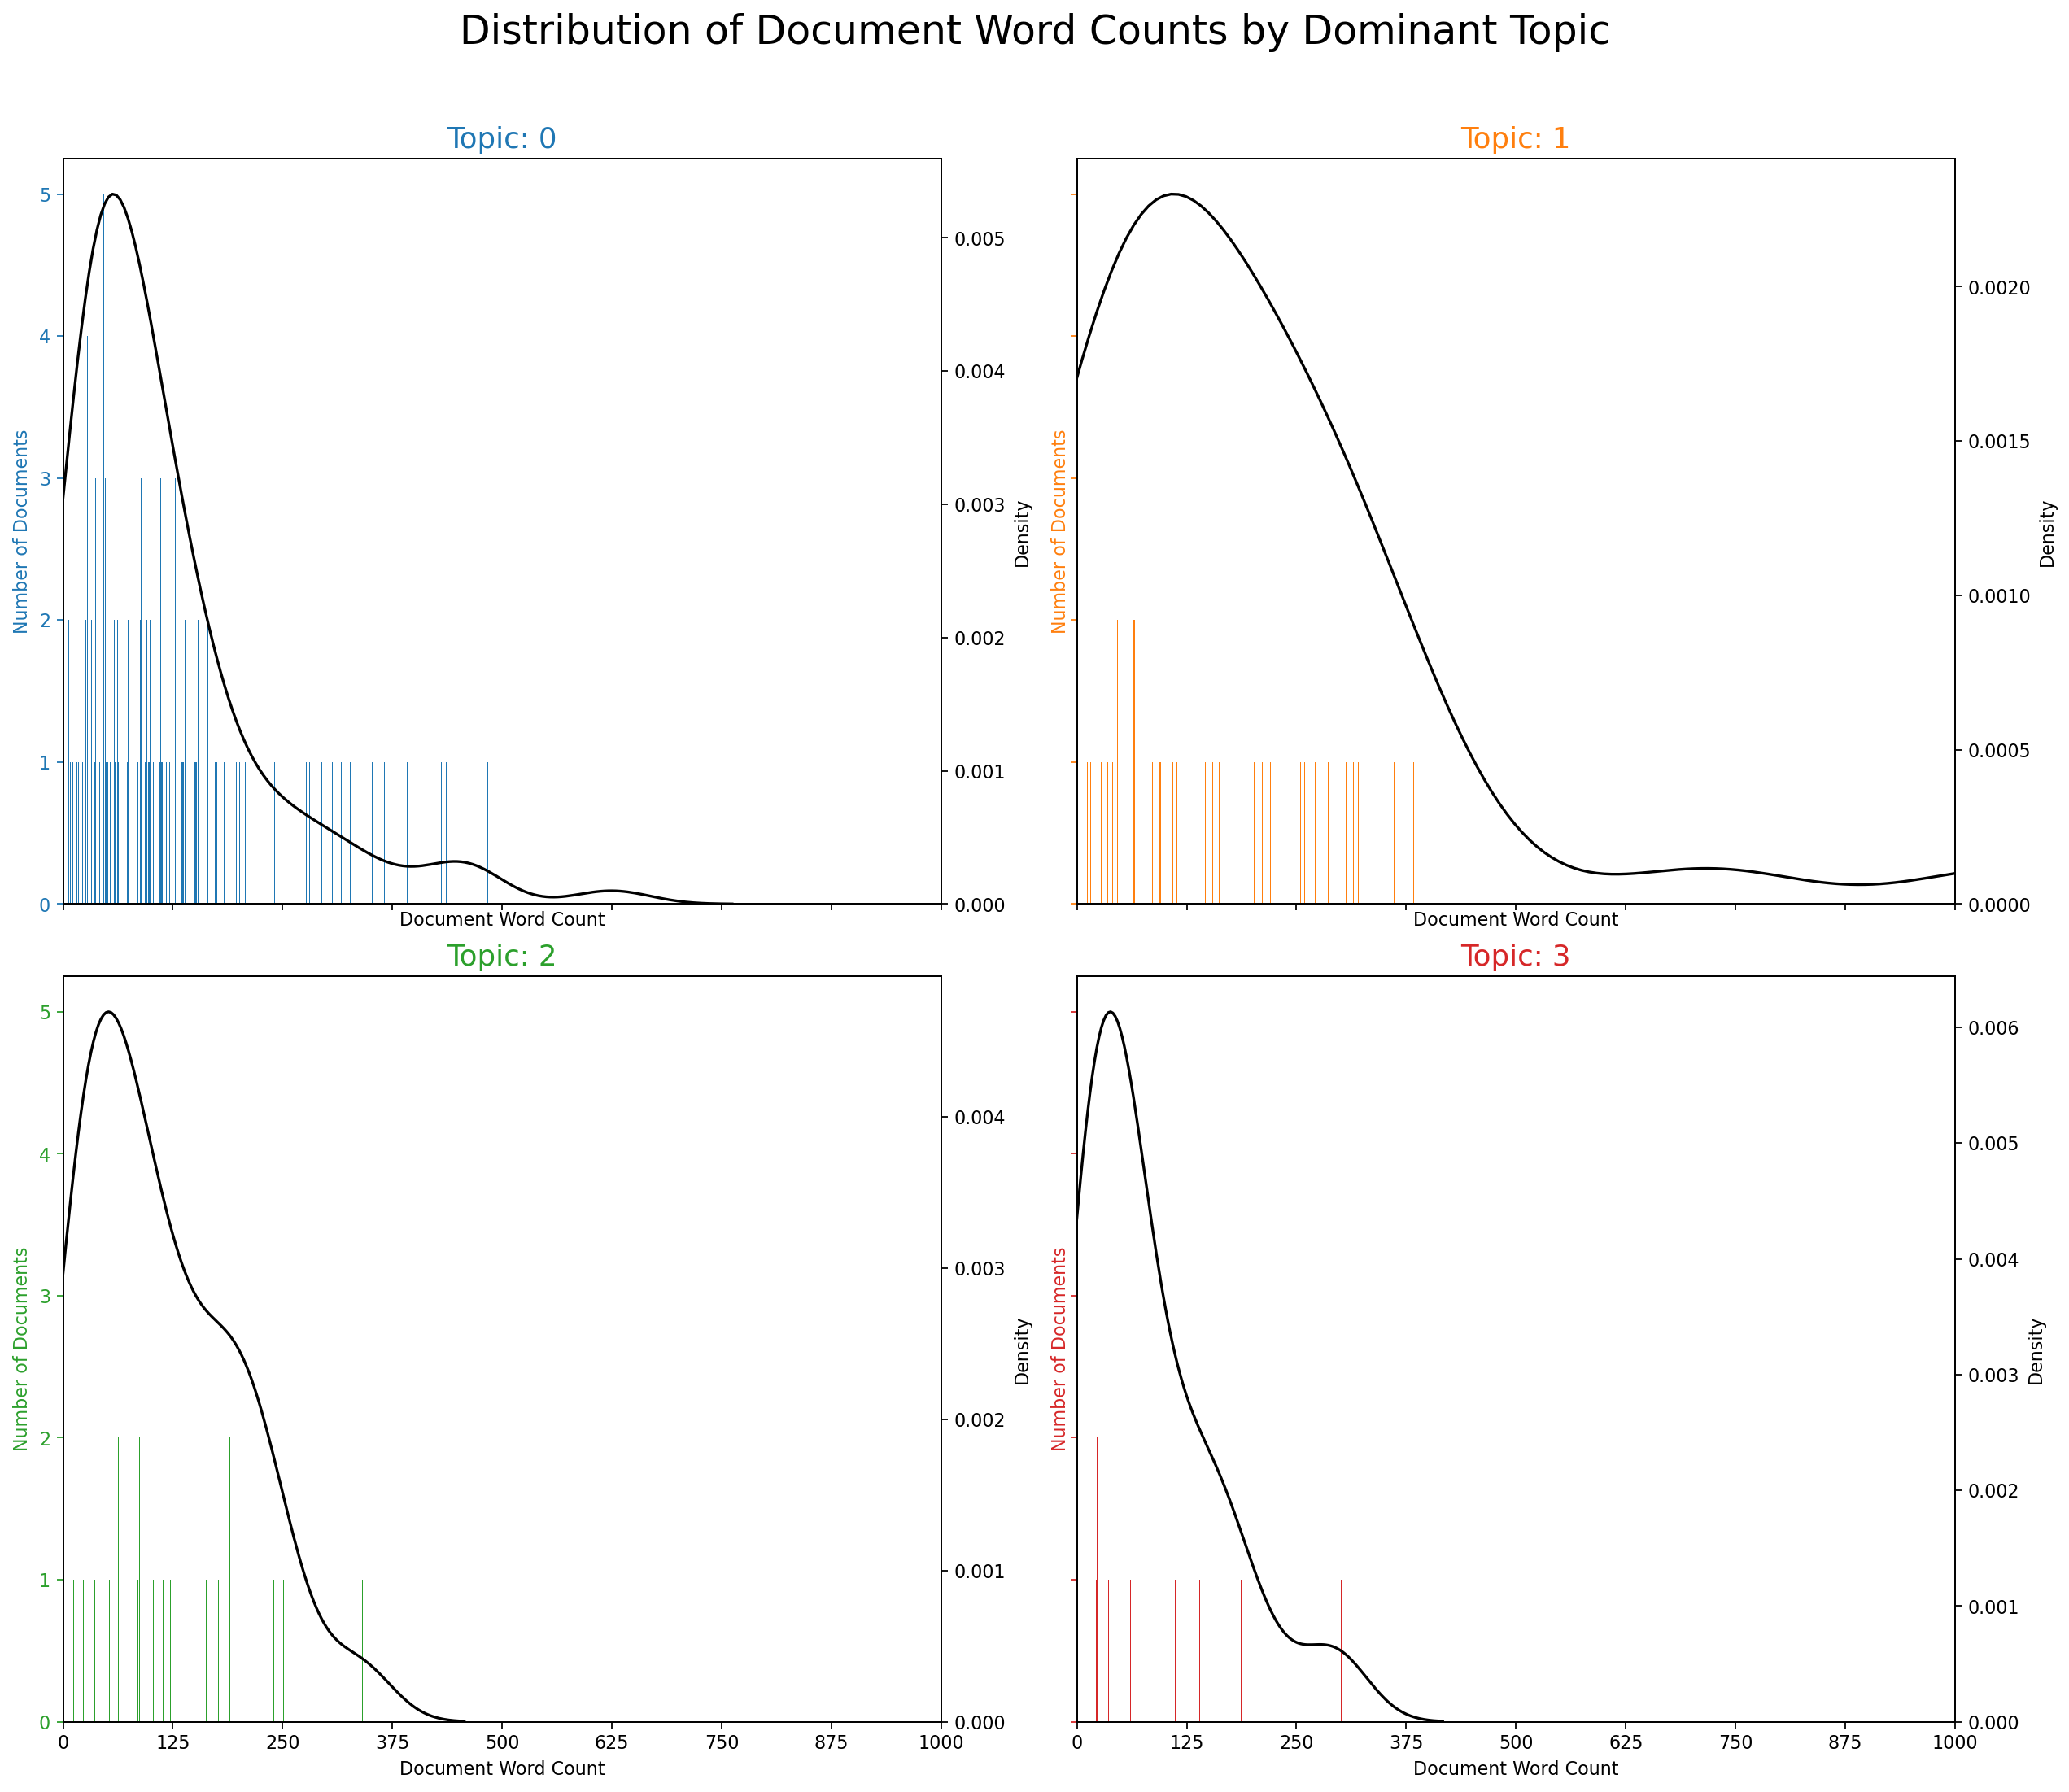

In [9]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# 9. Word Clouds of Top N Keywords in Each Topic

Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

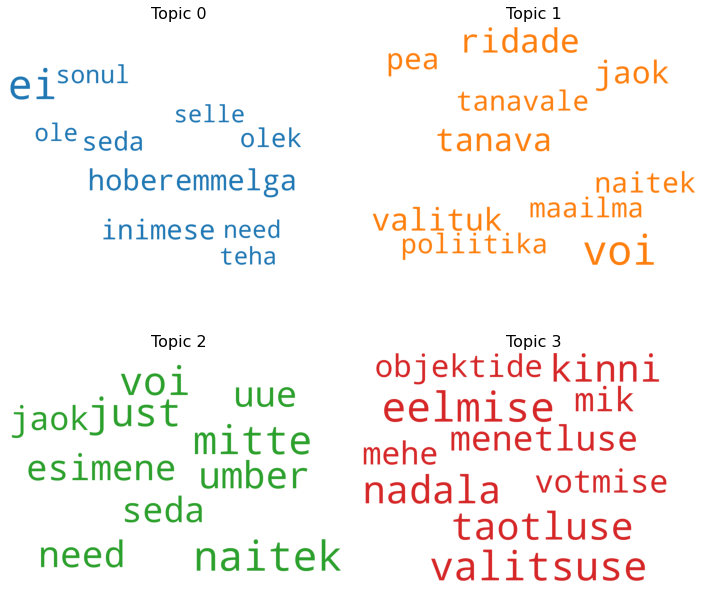

In [10]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# 10. Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.
You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


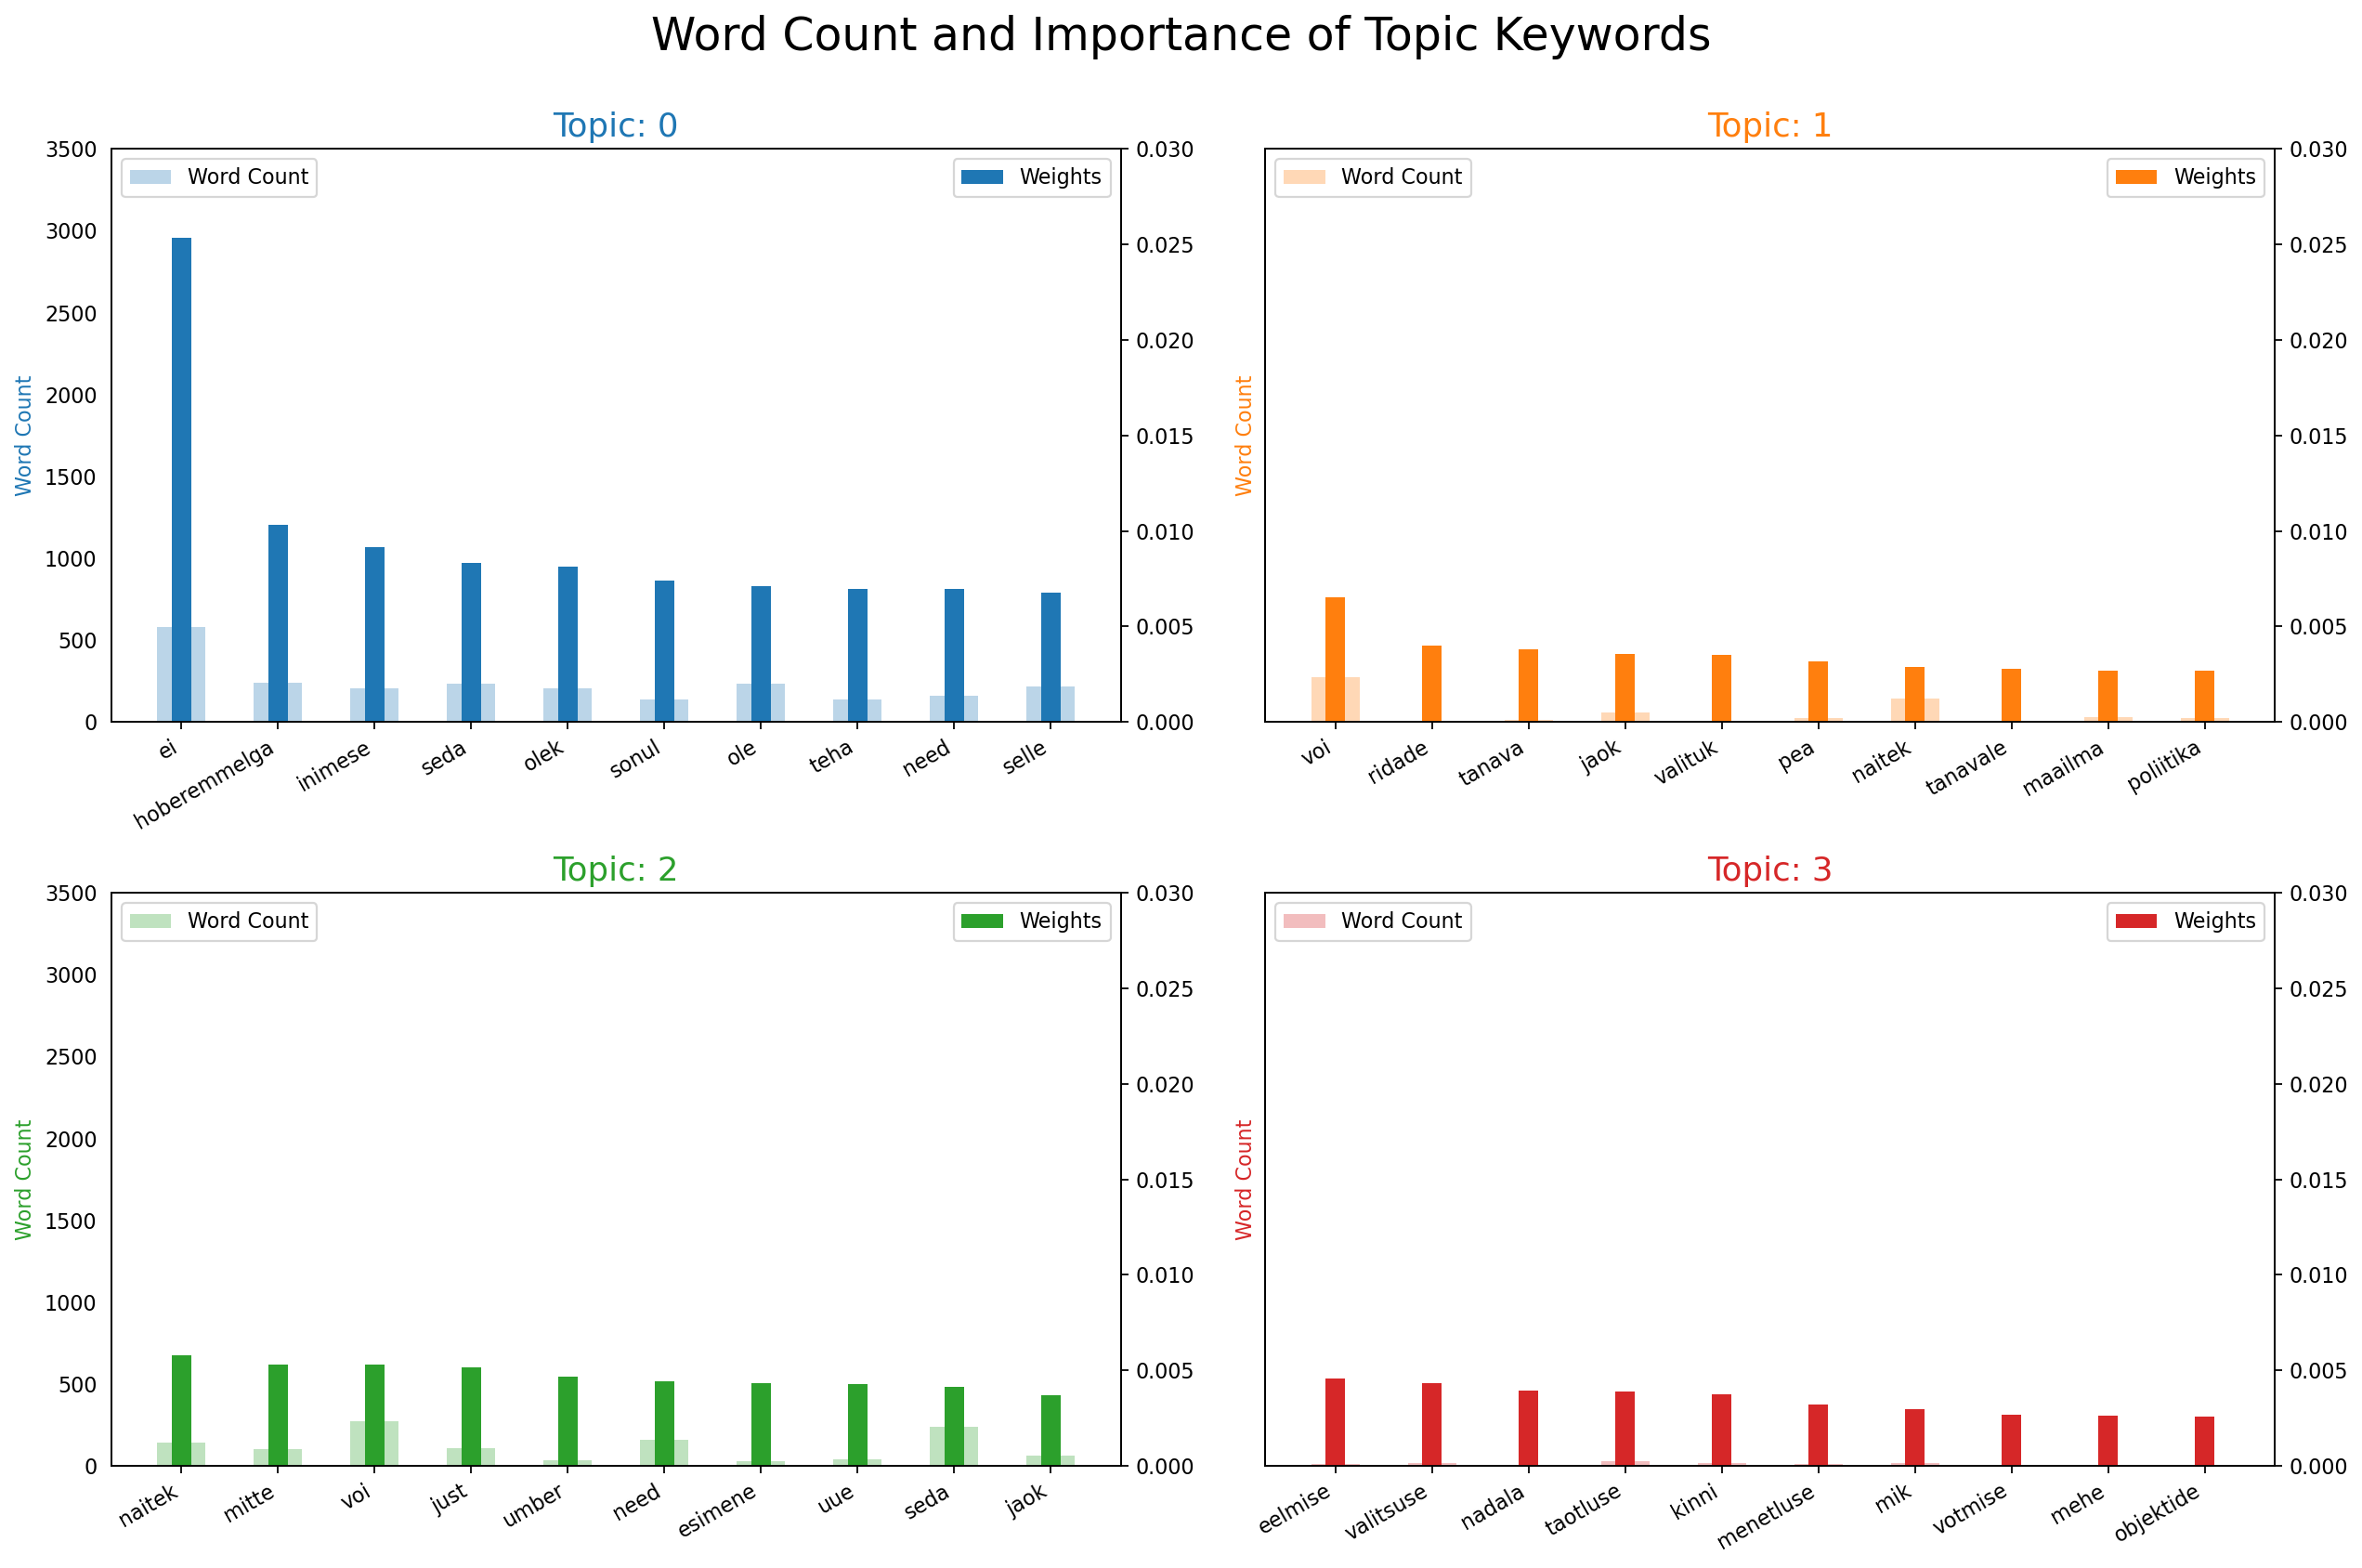

In [11]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# 11. Sentence Chart Colored by Topic

Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

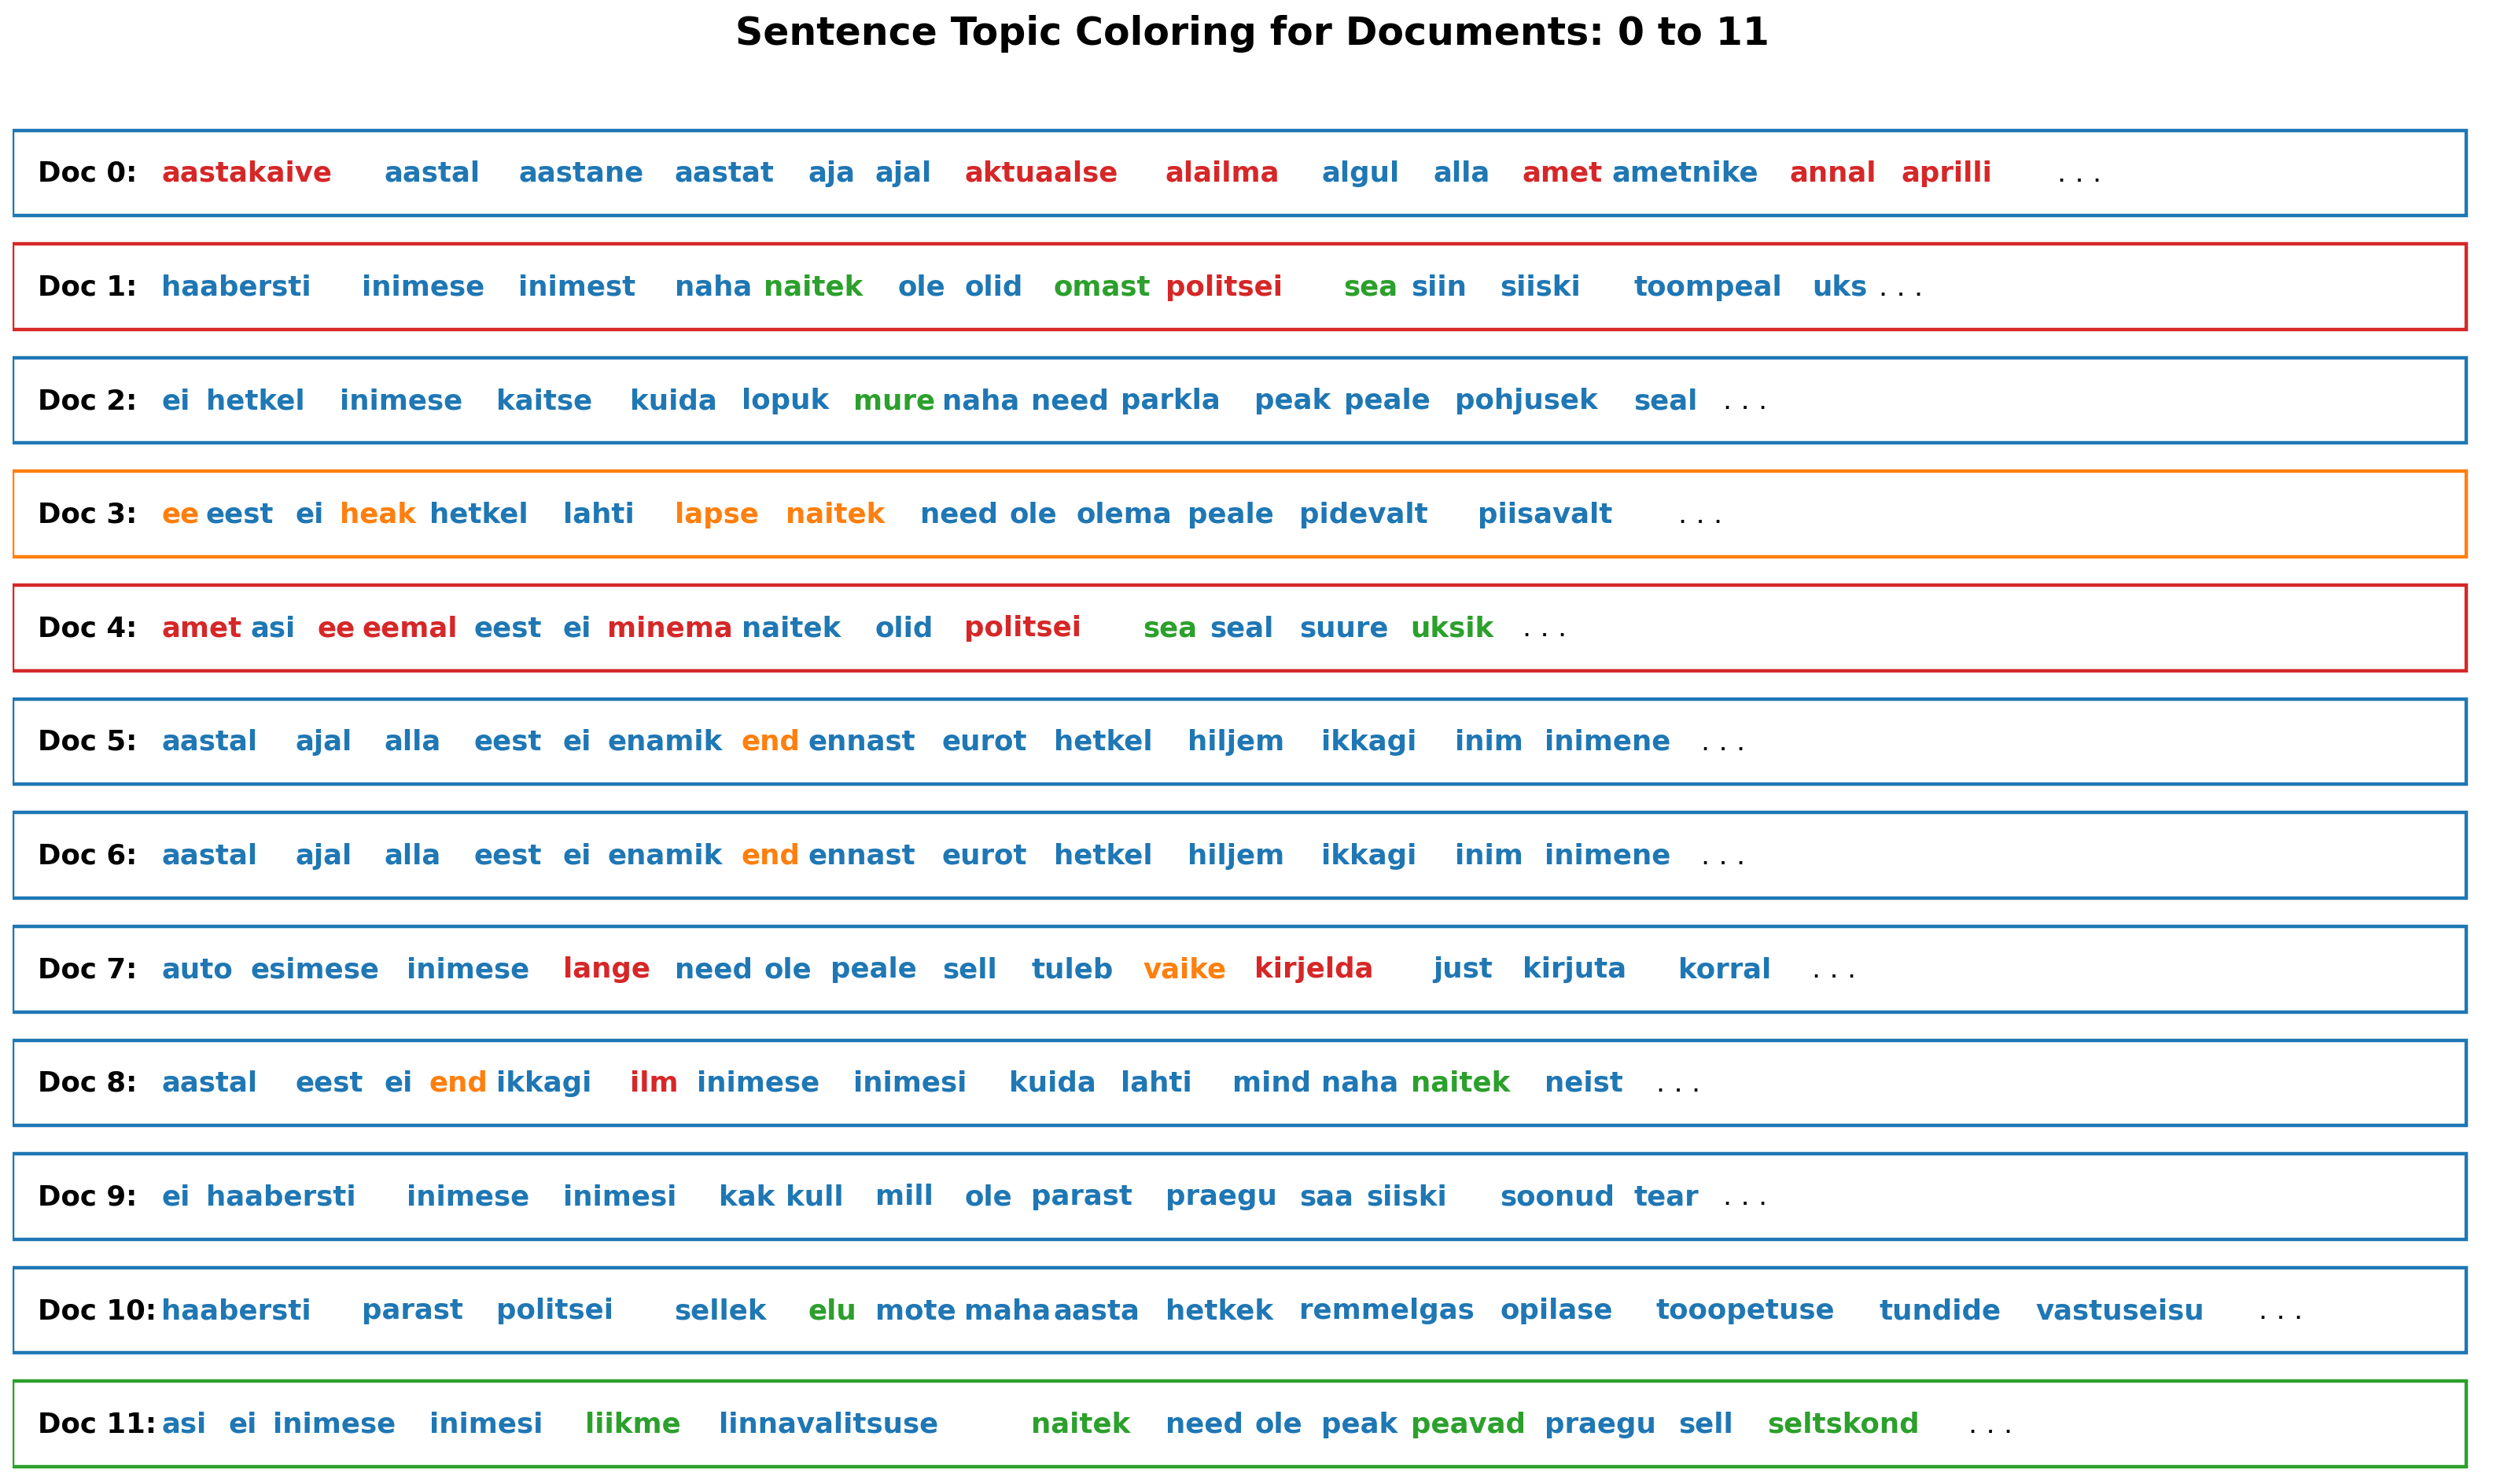

In [12]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

# 12. What are the most discussed topics in the documents?

Let’s compute the total number of documents attributed to each topic.

In [13]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let’s make two plots:

The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

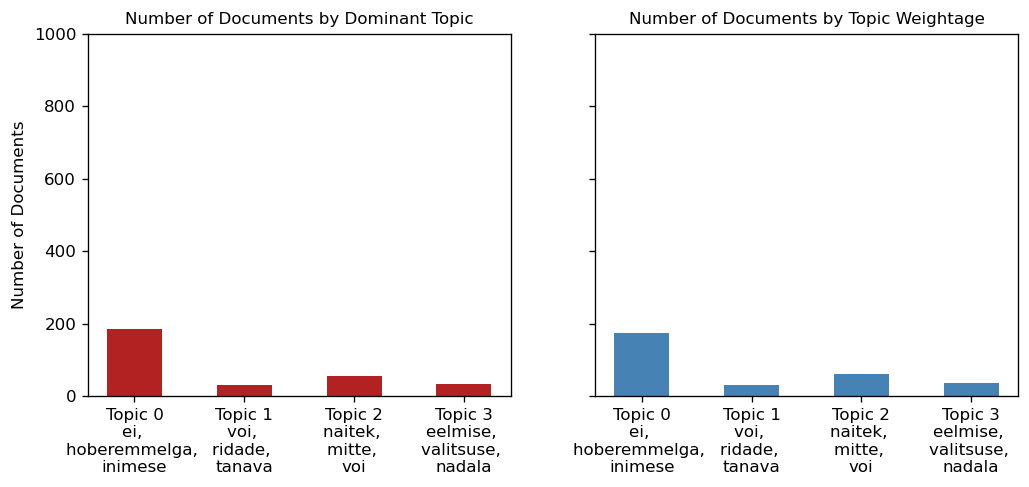

In [14]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

# 13. t-SNE Clustering Chart

Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [15]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 305 samples in 0.001s...
[t-SNE] Computed neighbors for 305 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 305 / 305
[t-SNE] Mean sigma: 0.038297
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.379822
[t-SNE] KL divergence after 850 iterations: 0.196611


Loading BokehJS ...

# 14. pyLDAVis

Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for LdaModel().

In [16]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.221407 -0.027061       1        1  52.749801
2     -0.036827  0.153168       2        1  20.566950
1     -0.092515 -0.049149       3        1  16.861395
3     -0.092065 -0.076958       4        1   9.821854, topic_info=           Term        Freq       Total Category  logprob  loglift
40           ei  520.000000  520.000000  Default  30.0000  30.0000
90      inimese  178.000000  178.000000  Default  29.0000  29.0000
603        olek  158.000000  158.000000  Default  28.0000  28.0000
652       sonul  145.000000  145.000000  Default  27.0000  27.0000
2857      ernit  131.000000  131.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2008   tegemine    6.078948    7.730093   Topic4  -6.3923   2.0803
1468       toid    7.848174   17.525551   Topic4  -6.1369   1.5172
274      peavad    8.263821   30.879189   Topic4  -6.0853   1.0024
286    politsei    7.024956   30.418984   Topic4  -6.2477   0.8550
2452  roheliste    6.288035   21.076422   Topic4  -6.3585   1.1111

[225 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1476      2  0.987789     aastast
921       1  0.976793  aktivistid
9         1  0.978475        alla
522       1  0.987592        alle
469       4  0.844684       andre
...     ...       ...         ...
2633      4  0.923474    voimalus
683       1  0.059340   voimaluse
683       2  0.890103   voimaluse
5289      1  0.091908     votmise
5289      4  0.919077     votmise

[263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

# 15. Conclusion

We started from scratch by importing, cleaning and processing the newsgroups dataset to build the LDA model. Then we saw multiple ways to visualize the outputs of topic models including the word clouds and sentence coloring, which intuitively tells you what topic is dominant in each topic. A t-SNE clustering and the pyLDAVis are provide more details into the clustering of the topics.

Where next? If you are familiar with scikit learn, you can build and grid search topic models using scikit learn as well.